Carga de librerías

In [1]:
# System management packages
import os
import re
import sys
import warnings
from numba import NumbaDeprecationWarning

sys.path.append('../src')
warnings.filterwarnings(action='ignore', category=NumbaDeprecationWarning)

# Data science packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio

# Geospatial packages
import h3
import geopandas as gpd
from shapely import Polygon

# Personal packages
from settings import Settings

# Notebook settings
settings = Settings()

# Selección de fuente de datos

In [2]:
# Data directory and list of files
DATA_BASE_DIR = os.path.join(settings.ROOT, 'data')
RAW_DATA = os.path.join(DATA_BASE_DIR, 'datos-produccion-maiz')

file_selector = 'hist-maize-panel-rcp2p6.csv'

In [3]:
# Store file_selector output in variable
file_path = os.path.join(RAW_DATA, file_selector)

# Extract AIRCCA base model and h3 mesh resolution
get_aircca_model = re.compile(r'rcp[0-9]p[0-9]')
model_pointer = get_aircca_model.search(file_path).group()

print(f'Model pointer: {model_pointer.upper()}')

Model pointer: RCP2P6


In [4]:
# Load data into dataframe object
data = (
    pd.read_csv(file_path)
    .query("year >= 2005 and year <= 2020")
    .assign(
        h3_polygon = lambda df: df.apply(
            func=lambda row: h3.latlng_to_cell(
                lat=row.lat,
                lng=row.lon,
                res=3),
            axis=1))
)

# Drop __ignore and format column names
data.drop(
    columns=[col for col in data.columns if col.__contains__('__ignore')]
    ,inplace=True)

data.columns = [
    re.sub(
        pattern=r'[-\. ]'
        ,repl='_'
        ,string=colname.lower().strip())
    for colname in data.columns]

# List of ordinary predictors, non geographical nor temporal data
ordinary_predictors = [var for var in data.columns if var.startswith('mean')]

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 502528 entries, 0 to 2826645
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   lon            502528 non-null  float64
 1   lat            502528 non-null  float64
 2   year           502528 non-null  int64  
 3   mean_precip    502528 non-null  float64
 4   mean_precip_2  502528 non-null  float64
 5   mean_temp      502528 non-null  float64
 6   mean_temp_2    502528 non-null  float64
 7   mean_yield     502528 non-null  float64
 8   id             502528 non-null  int64  
 9   h3_polygon     502528 non-null  object 
dtypes: float64(7), int64(2), object(1)
memory usage: 42.2+ MB


In [42]:
def normalize(series):
    min_x = min(series)
    max_x = max(series)
    return [(x - min_x) / (max_x - min_x) for x in series]

geo_data = (
    data
    .groupby(by=['year','h3_polygon'])
    .agg(
        mean_precip=('mean_precip','mean'),
        mean_temp=('mean_temp','mean'),
        mean_yield=('mean_yield','mean'))
    .reset_index()
    .assign(
        mean_temp_2 = lambda df: df.mean_temp ** 2,
        mean_precip_2 = lambda df: df.mean_precip ** 2,
        mean_temp_precip = lambda df: df.mean_temp * df.mean_precip,
        mean_temp_norm = lambda df: normalize(df.mean_temp),
        mean_precip_norm = lambda df: normalize(df.mean_precip),
        mean_precip_log = lambda df: np.log(df.mean_precip + 1),
        geometry=lambda df: df.apply(
            func=lambda row: Polygon(h3.cell_to_boundary(h=row.h3_polygon, geo_json=True)),
            axis=1),))

geo_data = gpd.GeoDataFrame(data=geo_data, crs='EPSG:4326', geometry='geometry')
geo_data

,year,h3_polygon,mean_precip,mean_temp,mean_yield,mean_temp_2,mean_precip_2,mean_temp_precip,mean_temp_norm,mean_precip_norm,mean_precip_log,geometry
0,2005,830830fffffffff,135.535666,6.878748,4.088000,47.317168,18369.916761,932.315632,0.415922,0.184481,4.916586,"POLYGON ((6.7913 63.96438, 5.86142 63.76021, 5..."
1,2005,830833fffffffff,141.146942,6.657940,3.493000,44.328167,19922.459125,939.747892,0.410898,0.192118,4.956861,"POLYGON ((8.7221 63.84278, 7.79997 63.65181, 7..."
2,2005,830880fffffffff,37.758546,5.284874,4.202306,27.929895,1425.707806,199.549167,0.379657,0.051394,3.657351,"POLYGON ((17.25045 60.41134, 17.26259 59.92157..."
3,2005,830882fffffffff,33.763414,5.596905,3.627000,31.325346,1139.968135,188.970622,0.386756,0.045956,3.548566,"POLYGON ((18.26105 59.69862, 18.26353 59.20079..."
4,2005,830883fffffffff,34.930048,4.579902,4.276000,20.975499,1220.108246,159.976183,0.363617,0.047544,3.581574,"POLYGON ((19.26639 60.45218, 19.25929 59.96206..."
...,...,...,...,...,...,...,...,...,...,...,...,...
131371,2020,83df69fffffffff,49.988634,7.474858,1.195000,55.873496,2498.863568,373.657923,0.429485,0.068041,3.931603,"POLYGON ((-69.95214 -53.07264, -69.65477 -52.4..."
131372,2020,83df6afffffffff,42.649679,5.634246,0.045000,31.744726,1818.995101,240.298774,0.387606,0.058051,3.776196,"POLYGON ((-68.78038 -54.4019, -67.76989 -54.20..."
131373,2020,83df6bfffffffff,27.138607,7.924384,1.401000,62.795863,736.503980,215.056743,0.439713,0.036939,3.337143,"POLYGON ((-69.26758 -53.47305, -68.28476 -53.2..."
131374,2020,83df6dfffffffff,83.412939,6.918442,0.667000,47.864840,6957.718445,577.087585,0.416825,0.113535,4.435721,"POLYGON ((-71.18795 -53.76908, -70.86533 -53.1..."


# Visualización inicial

In [43]:
geo_data.mean_precip_log.describe()

count    131376.000000
mean          4.155004
std           0.993037
min           0.000030
25%           3.709620
50%           4.283226
75%           4.828855
max           6.600806
Name: mean_precip_log, dtype: float64

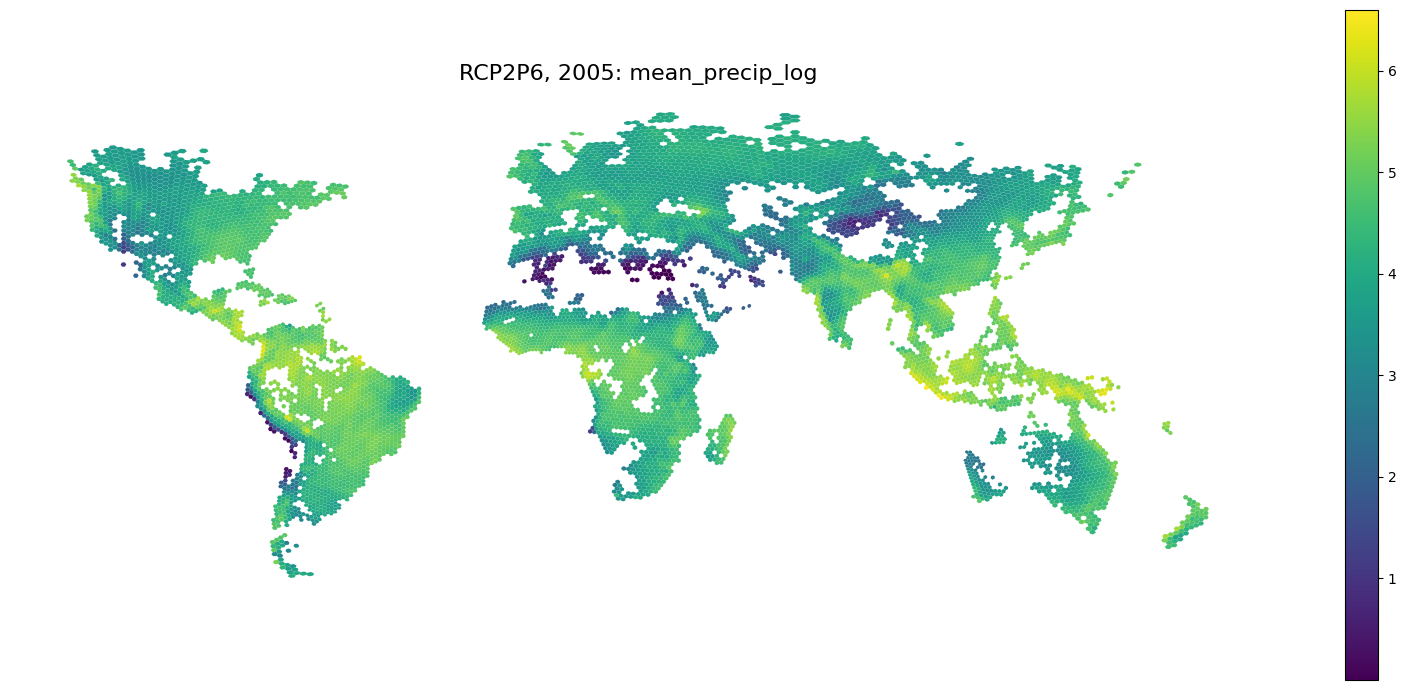

In [44]:
year = 2005
variable = 'mean_precip_log'

# Datos de visualización
_vis = (
    geo_data
    .query(f"year == {year}"))

# Especificaciones de figura
fig, ax = plt.subplots(figsize=(16,7))

# Elementos de visualización
map = _vis.plot(
    column=variable,
    ax=ax,
    legend=True,
    vmin=geo_data[variable].min(),
    vmax=geo_data[variable].max(),)

# Annotations and styling
ax.set_title(
    label=f'{model_pointer.upper()}, {year}: {variable}'
    ,fontsize=16)
ax.set_yticks([])
ax.set_xticks([])
ax.set_frame_on(False)

fig.tight_layout()

plt.show()

In [45]:
for variable in ['mean_precip_log',]:
    for year in geo_data.year.unique():
        print(f"{variable}:{year}")
        # Datos de visualización
        _vis = (
            geo_data
            .query(f"year == {year}"))

        # Especificaciones de figura
        fig, ax = plt.subplots(figsize=(16,7))

        # Elementos de visualización
        map = _vis.plot(
            column=variable,
            ax=ax,
            legend=True,
            vmin=geo_data[variable].min(),
            vmax=geo_data[variable].max(),)

        # Annotations and styling
        ax.set_title(
            label=f'{model_pointer.upper()}, {year}: {variable}'
            ,fontsize=16)
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_frame_on(False)

        fig.tight_layout()
        fig.savefig(f"../figures/raw_vis/{variable}/h3_vis_{year}.png")

        plt.close()

mean_precip_log:2005
mean_precip_log:2006
mean_precip_log:2007
mean_precip_log:2008
mean_precip_log:2009
mean_precip_log:2010
mean_precip_log:2011
mean_precip_log:2012
mean_precip_log:2013
mean_precip_log:2014
mean_precip_log:2015
mean_precip_log:2016
mean_precip_log:2017
mean_precip_log:2018
mean_precip_log:2019
mean_precip_log:2020


In [46]:
# 'mean_temp_2', 'mean_precip_2', 'mean_temp_precip', 'mean_temp_norm','mean_precip_norm', 'mean_precip_log'
variable = "mean_precip_log"

# List of image file paths
image_files = os.listdir(f'../figures/raw_vis/{variable}')

# Read images and save as GIF
images = [
    imageio.imread(f"../figures/raw_vis/{variable}/{image}")
    for image in image_files
    if image.__contains__('h3_vis')]
imageio.mimsave(f'../figures/raw_vis/{variable}_h3.gif', images, format='GIF', duration=500, loop=4)

C:\Users\Miguel\AppData\Local\Temp\ipykernel_26460\2773733239.py:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imageio.imread(f"../figures/raw_vis/{variable}/{image}")


# Autocorrelación espacial global

## Inspección inicial

In [11]:
import seaborn as sns
from pysal.lib import weights

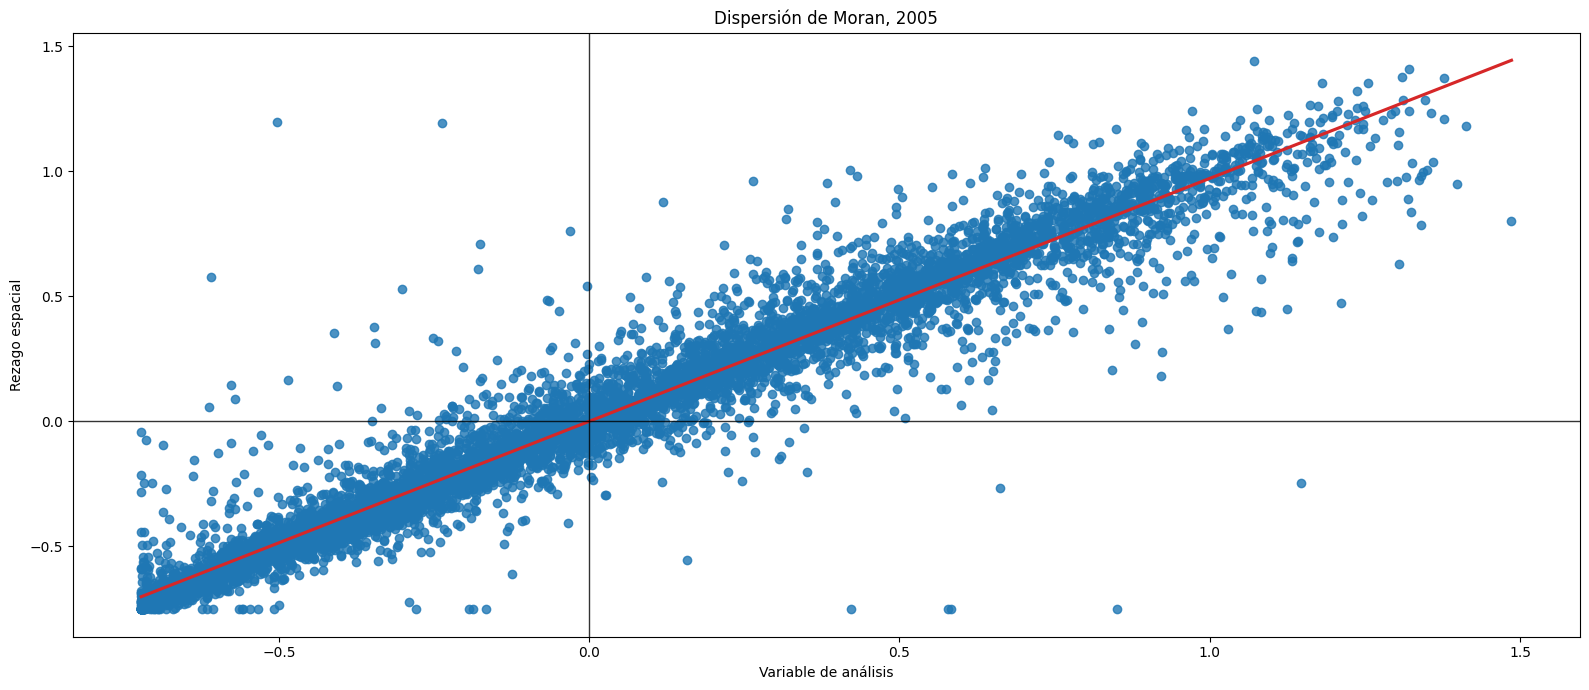

In [13]:
year = 2005
variable = 'mean_yield'

# Visualization data
_vis = (
    geo_data
    .query(f"year == {year}"))

# Matriz de pesos bajo criterio de reinas
w = weights.Queen.from_dataframe(
    df=_vis,
    geom_col="geometry",
    use_index=True,
    silence_warnings=True)

# Estandarización por renglón
w.set_transform(value='R')

# Calcular columnas de rezago
_vis = (
    _vis
    .assign(
        # Rezago espacial de la variable de interés
        lag = lambda _df: weights.spatial_lag.lag_spatial(w=w, y=_df[variable])
        # Centrar a la media y escalar a 2 std
        ,scaled = lambda _df: (_df[variable] - _df[variable].mean()) / (_df[variable].std() * 2)
        ,lag_scaled = lambda _df: (_df.lag - _df.lag.mean()) / (_df.lag.std() * 2)))

# Figure config
fig, ax = plt.subplots(figsize=(16,7))

# Elementos de visualización
sns.regplot(
    data=_vis,
    x='scaled',
    y='lag_scaled',
    ci=None,
    line_kws=dict(color='tab:red'),
    ax=ax)
ax.axvline(0, color='black', linewidth=1, alpha=0.8)
ax.axhline(0, color='black', linewidth=1, alpha=0.8)


# Anotaciones y estilo
ax.set(
    title=f'Dispersión de Moran, {year}'
    ,xlabel='Variable de análisis'
    ,ylabel='Rezago espacial')

fig.tight_layout()
#fig.savefig(f"../figures/autocor/{variable}/global/glob_autocor_{year}.png")

plt.show()

## Para todos los periodos

In [14]:
for variable in ['mean_yield']:
    for year in geo_data.year.unique():
        print(f"{variable}:{year}")
        # Visualization data
        _vis = (
            geo_data
            .query(f"year == {year}"))

        # Matriz de pesos bajo criterio de reinas
        w = weights.Queen.from_dataframe(
            df=_vis,
            geom_col="geometry",
            use_index=True,
            silence_warnings=True)

        # Estandarización por renglón
        w.set_transform(value='R')

        # Calcular columnas de rezago
        _vis = (
            _vis
            .assign(
                # Rezago espacial de la variable de interés
                lag = lambda _df: weights.spatial_lag.lag_spatial(w=w, y=_df[variable])
                # Centrar a la media y escalar a 2 std
                ,scaled = lambda _df: (_df[variable] - _df[variable].mean()) / (_df[variable].std() * 2)
                ,lag_scaled = lambda _df: (_df.lag - _df.lag.mean()) / (_df.lag.std() * 2)))

        # Figure config
        fig, ax = plt.subplots(figsize=(16,7))

        # Elementos de visualización
        sns.regplot(
            data=_vis,
            x='scaled',
            y='lag_scaled',
            ci=None,
            line_kws=dict(color='tab:red'),
            ax=ax)
        ax.axvline(0, color='black', linewidth=1, alpha=0.8)
        ax.axhline(0, color='black', linewidth=1, alpha=0.8)


        # Anotaciones y estilo
        ax.set(
            title=f'Dispersión de Moran, {year}'
            ,xlabel='Variable de análisis'
            ,ylabel='Rezago espacial')

        fig.tight_layout()
        fig.savefig(f"../figures/autocor/{variable}/global/h3_glob_autocor_{year}.png")

        plt.close()

mean_yield:2005
mean_yield:2006
mean_yield:2007
mean_yield:2008
mean_yield:2009
mean_yield:2010
mean_yield:2011
mean_yield:2012
mean_yield:2013
mean_yield:2014
mean_yield:2015
mean_yield:2016
mean_yield:2017
mean_yield:2018
mean_yield:2019
mean_yield:2020


In [16]:
variable = "mean_yield"

# List of image file paths
image_files = os.listdir(f'../figures/autocor/{variable}/global')

# Read images and save as GIF
images = [
    imageio.imread(f"../figures/autocor/{variable}/global/{image}")
    for image in image_files
    if image.__contains__('h3_glob')]
imageio.mimsave(f'../figures/autocor/h3_global_{variable}.gif', images, format='GIF', duration=500, loop=4)

C:\Users\Miguel\AppData\Local\Temp\ipykernel_2404\282653332.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imageio.imread(f"../figures/autocor/{variable}/global/{image}")


# Autocorrelación espacial local

## Inspección inicial

In [18]:
from pysal.explore import esda
from splot.esda import lisa_cluster

c:\Users\Miguel\Documents\Github\estancia\venv\Lib\site-packages\spaghetti\network.py:41: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)
c:\Users\Miguel\Documents\Github\estancia\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


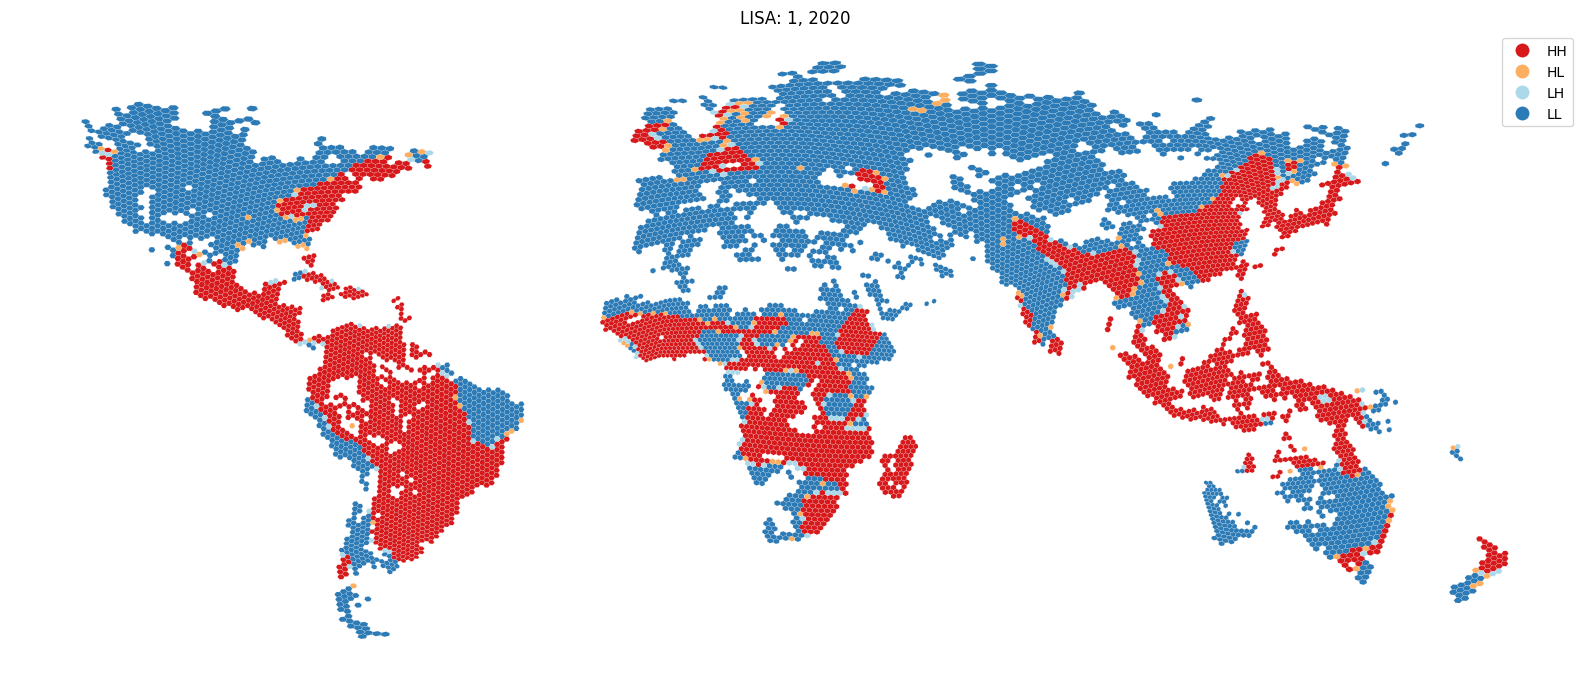

In [ ]:
p = 1
# Visualization data
_vis = (
    geo_data
    .query(f"year == {year}"))

# Matriz de pesos bajo criterio de reinas
w = weights.Queen.from_dataframe(
    df=_vis,
    geom_col="geometry",
    use_index=True,
    silence_warnings=True)

# Estandarización por renglón
w.set_transform(value='R')

# Calcular columnas de rezago
_vis = (
    _vis
    .assign(
        # Rezago espacial de la variable de interés
        lag = lambda _df: weights.spatial_lag.lag_spatial(w=w, y=_df[variable]),
        # Centrar a la media y escalar a 2 std
        scaled = lambda _df: (_df[variable] - _df[variable].mean()) / (_df[variable].std() * 2),
        lag_scaled = lambda _df: (_df.lag - _df.lag.mean()) / (_df.lag.std() * 2)))

# Estadístico Moran I local
_vis_lisa = esda.moran.Moran_Local(
    y=_vis[variable]
    ,w=w
    ,transformation='R'
    ,permutations=1_000
    ,n_jobs=-1)

# Asignar valores de Moran's Local LISAs a datos originales
_vis = _vis.assign(ML_Is=_vis_lisa.Is)

# Figure config
fig, ax = plt.subplots(figsize=(16,7))

# Elementos de visualización
lisa_cluster(
    moran_loc=_vis_lisa,
    gdf=gpd.GeoDataFrame(_vis),
    p=p,
    ax=ax,)


# Anotaciones y estilo
ax.set(title=f'LISA: {p}, {year}',)

fig.tight_layout()

plt.show()

## Para todos los periodos

In [30]:
p = 0.05
for variable in ['mean_yield']:
    for year in data.year.unique():
        print(f"{variable}:{year}")
        # Visualization data
        _vis = (
            geo_data
            .query(f"year == {year}"))

        # Matriz de pesos bajo criterio de reinas
        w = weights.Queen.from_dataframe(
            df=_vis,
            geom_col="geometry",
            use_index=True,
            silence_warnings=True)

        # Estandarización por renglón
        w.set_transform(value='R')

        # Calcular columnas de rezago
        _vis = (
            _vis
            .assign(
                # Rezago espacial de la variable de interés
                lag = lambda _df: weights.spatial_lag.lag_spatial(w=w, y=_df[variable]),
                # Centrar a la media y escalar a 2 std
                scaled = lambda _df: (_df[variable] - _df[variable].mean()) / (_df[variable].std() * 2),
                lag_scaled = lambda _df: (_df.lag - _df.lag.mean()) / (_df.lag.std() * 2)))

        # Estadístico Moran I local
        _vis_lisa = esda.moran.Moran_Local(
            y=_vis[variable]
            ,w=w
            ,transformation='R'
            ,permutations=1_000
            ,n_jobs=-1)

        # Asignar valores de Moran's Local LISAs a datos originales
        _vis = _vis.assign(ML_Is=_vis_lisa.Is)

        # Figure config
        fig, ax = plt.subplots(figsize=(16,7))

        # Elementos de visualización
        lisa_cluster(
            moran_loc=_vis_lisa,
            gdf=gpd.GeoDataFrame(_vis),
            p=p,
            ax=ax,)


        # Anotaciones y estilo
        ax.set(
            title=f'LISA: {p}, {year}',)

        fig.tight_layout()

        fig.savefig(f"../figures/autocor/{variable}/local/h3_local_p{str(p).split('.')[-1]}_autocor_{year}.png")

        plt.close()

mean_yield:2005
mean_yield:2006
mean_yield:2007
mean_yield:2008
mean_yield:2009
mean_yield:2010
mean_yield:2011
mean_yield:2012
mean_yield:2013
mean_yield:2014
mean_yield:2015
mean_yield:2016
mean_yield:2017
mean_yield:2018
mean_yield:2019
mean_yield:2020


In [31]:
variable = "mean_yield"

# List of image file paths
image_files = os.listdir(f'../figures/autocor/{variable}/local')

# Read images and save as GIF
images = [
    imageio.imread(f"../figures/autocor/{variable}/local/{image}")
    for image in image_files
    if image.__contains__(f'h3_local_p{str(p).split(".")[-1]}')]
imageio.mimsave(f'../figures/autocor/h3_local_p{str(p).split(".")[-1]}_{variable}.gif', images, format='GIF', duration=500, loop=4)

C:\Users\Miguel\AppData\Local\Temp\ipykernel_2404\1477925755.py:8: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imageio.imread(f"../figures/autocor/{variable}/local/{image}")
